In [1]:
import os
import pickle
import joblib
import numpy as np
from mne import viz
from scipy import io
import lime, lime.lime_tabular
from matplotlib import colors, pyplot as plt
from sklearn import model_selection, neural_network, ensemble

In [2]:
CAF_DOSE = 200
NUM_TEST_SUBJECTS = 10

CLASSIFIER = 'RandomForest' # MLP, RandomForest

PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\Features{dose}\\Combined'.format(dose=CAF_DOSE)
PROJECT_PATH = 'E:\\Cafeine_data'

STAGES = ['AWA', 'NREM', 'REM']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
with open(os.path.join(PATH, 'data_avg.pickle'), 'rb') as file:
    data = pickle.load(file)
with open(os.path.join(PATH, 'labels_avg.pickle'), 'rb') as file:
    labels = pickle.load(file)
with open(os.path.join(PATH, 'groups_avg.pickle'), 'rb') as file:
    groups = pickle.load(file)

In [5]:
def get_mask(group, out, invert=False):
    mask = np.ones(group.shape, dtype=np.bool)
    for element in out:
        mask = mask & (group != element)
    if invert:
        return np.invert(mask)
    else:
        return mask
    
test_subjects = set()
while len(test_subjects) < NUM_TEST_SUBJECTS:
    test_subjects.add(np.random.choice(np.unique(groups['AWA'])))
    
feature_names = []
feature_names_elec = []
    
data_train = {}
data_test = {}
labels_train = {}
labels_test = {}
groups_train = {}
for stage in STAGES:
    data_train[stage] = []
    data_test[stage] = []
    labels_train[stage] = []
    labels_test[stage] = []
    
    for feature in data[stage].keys():
        data_train[stage].append(data[stage][feature][get_mask(groups[stage], test_subjects)])
        data_test[stage].append(data[stage][feature][get_mask(groups[stage], test_subjects, invert=True)])
        
        feature_names.append(feature)
        for electrode in range(20):
            name = f'e{electrode} {feature}'
            if name not in feature_names_elec:
                feature_names_elec.append(name)
    
    data_train[stage] = np.concatenate(data_train[stage], axis=1)
    data_test[stage] = np.concatenate(data_test[stage], axis=1)
    
    labels_train[stage] = labels[stage][get_mask(groups[stage], test_subjects)]
    labels_test[stage] = labels[stage][get_mask(groups[stage], test_subjects, invert=True)]
    
    groups_train[stage] = groups[stage][get_mask(groups[stage], test_subjects)]

In [6]:
print(f'Training data: {data_train["AWA"].shape} (samples x features)')
print(f'Testing data : {data_test["AWA"].shape} (samples x features)')

Training data: (58, 200) (samples x features)
Testing data : (20, 200) (samples x features)


In [7]:
clf_searches = {}

for stage in STAGES:
    print(f'Performing grid search for {CLASSIFIER} on sleep stage {stage}...')
    
    if CLASSIFIER.lower() == 'mlp':
        clf = neural_network.MLPClassifier(max_iter=5000)
        grid = {'hidden_layer_sizes': [(256,), (128,), (64,), (32,),
                                       (256, 128), (256, 64), (128, 64), (64, 32),
                                       (128, 64, 32), (256, 128, 64)],
                'activation': ['relu', 'tanh']}
    elif CLASSIFIER.lower() == 'randomforest':
        clf = ensemble.RandomForestClassifier()
        grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350],
                'criterion': ['gini', 'entropy']}
    
    clf_searches[stage] = model_selection.GridSearchCV(estimator=clf,
                                                       param_grid=grid,
                                                       scoring='accuracy',
                                                       cv=10,
                                                       iid=False,
                                                       n_jobs=-1)
    clf_searches[stage].fit(data_train[stage], labels_train[stage], groups=groups_train[stage])

Performing grid search for RandomForest on sleep stage AWA...
Performing grid search for RandomForest on sleep stage NREM...
Performing grid search for RandomForest on sleep stage REM...


In [8]:
for stage in STAGES:
    print(f'{stage:4}: {clf_searches[stage].best_score_ * 100:.2f}%', clf_searches[stage].best_params_)
    print(f'Testing accuracy: {clf_searches[stage].score(data_test[stage], labels_test[stage]) * 100:.2f}%')

AWA : 65.83% {'criterion': 'gini', 'n_estimators': 200}
Testing accuracy: 60.00%
NREM: 69.17% {'criterion': 'gini', 'n_estimators': 300}
Testing accuracy: 65.00%
REM : 55.00% {'criterion': 'gini', 'n_estimators': 350}
Testing accuracy: 50.00%


# True feature importances

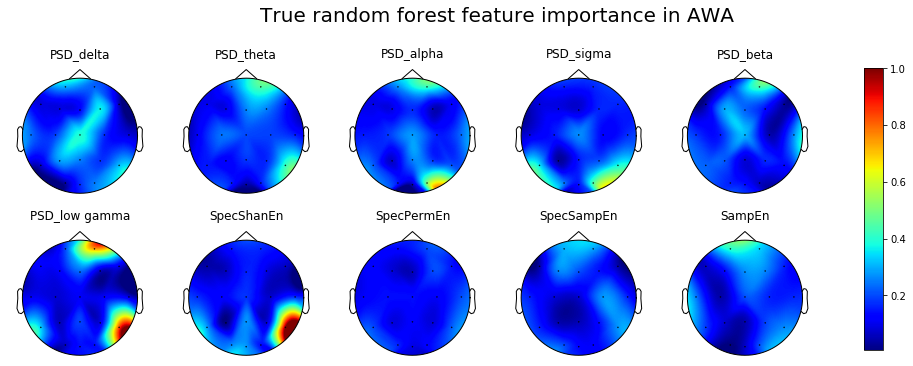

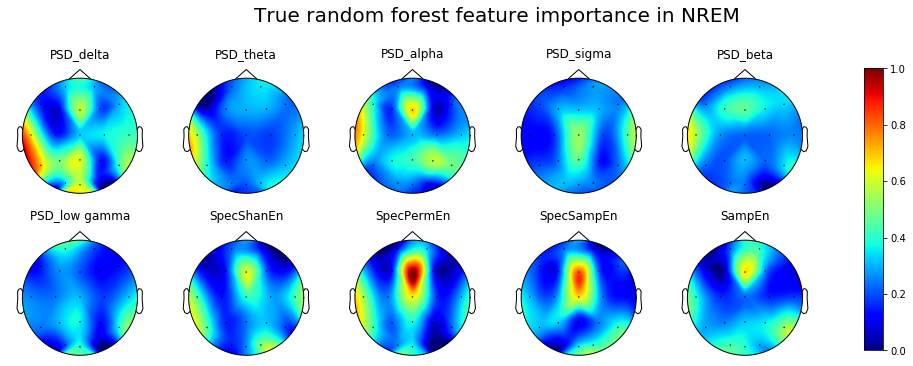

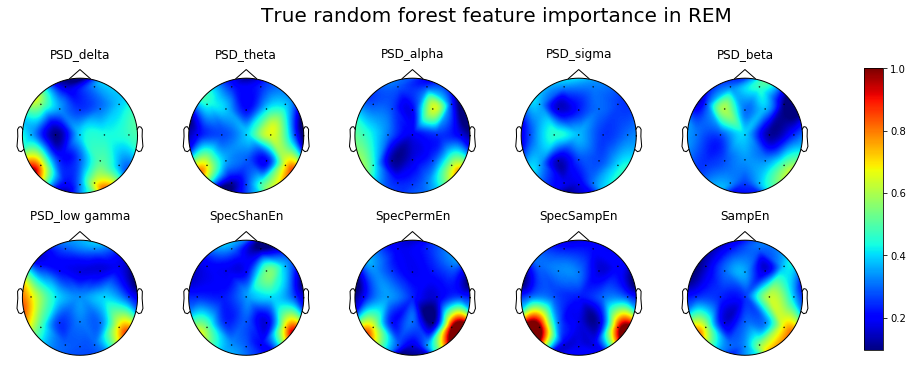

In [9]:
if CLASSIFIER.lower() == 'randomforest':
    colormap = 'jet'
    
    for stage in STAGES:
        axes = []
        plt.figure(figsize=(18, 5))
        plt.suptitle(f'True random forest feature importance in {stage}', fontsize=20, y=1.1)

        curr_importances = clf_searches[stage].best_estimator_.feature_importances_.reshape((20, -1))
        curr_importances = curr_importances / curr_importances.max()
        
        vmin = np.min(curr_importances)
        vmax = np.max(curr_importances)

        for i in range(curr_importances.shape[1]):
            axes.append(plt.subplot(2, 5, i + 1))
            plt.title(feature_names[i])
            curr = curr_importances[:,i]
            viz.plot_topomap(curr, sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)

        norm = colors.Normalize(vmin=vmin,vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
        plt.show()

# LIME feature importances

In [10]:
def explain(sample, label):
    exp = explainer.explain_instance(data_row=sample,
                                         labels=(0, 1),
                                         num_samples=5000,
                                         predict_fn=clf_searches[stage].predict_proba,
                                         num_features=len(feature_names_elec))
    
    indices = np.array([ft[0] for ft in exp.as_map()[label]])
    importance = np.array([ft[1] for ft in exp.as_map()[label]])
    return importance[indices], label

importances_plac = dict([(stage, np.zeros(len(feature_names_elec))) for stage in STAGES])
importances_caff = dict([(stage, np.zeros(len(feature_names_elec))) for stage in STAGES])
abs_importances = {}

for stage in STAGES:
    print(f'Calculating feature importances for stage {stage}...')
    explainer = lime.lime_tabular.LimeTabularExplainer(training_data=data_train[stage],
                                                       feature_names=feature_names_elec,
                                                       class_names=['PLAC', 'CAF'],
                                                       discretize_continuous=True)
    
    result = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(explain)(sample, label) for sample, label in zip(data_test[stage], labels_test[stage])
    )

    importances = np.array([res[0] for res in result])
    labels = np.array([res[1] for res in result])
    
    importances_caff[stage] = importances[labels==1].mean(axis=0)
    importances_plac[stage] = importances[labels==0].mean(axis=0)
    abs_importances[stage] = (np.abs(importances_plac[stage]) + np.abs(importances_caff[stage])) / 2

Calculating feature importances for stage AWA...
Calculating feature importances for stage NREM...
Calculating feature importances for stage REM...


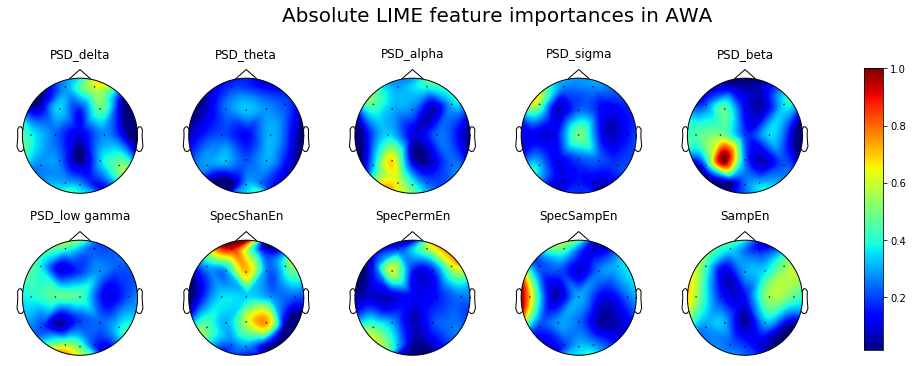

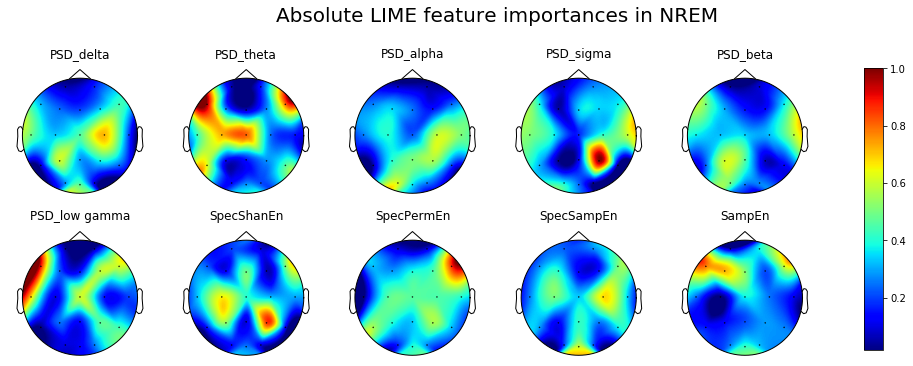

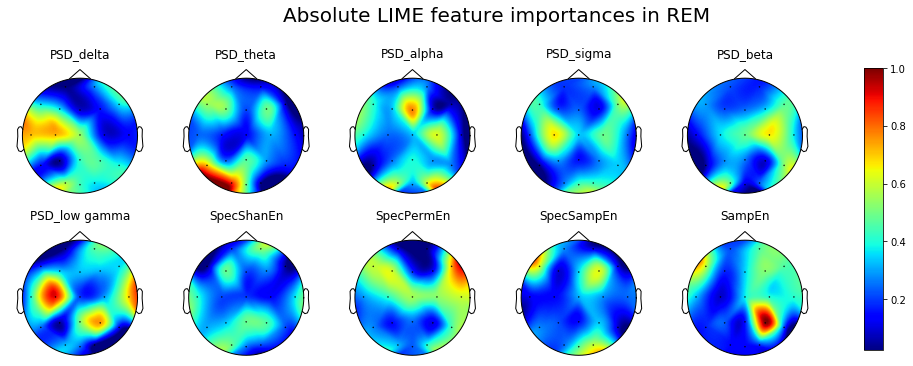

In [11]:
colormap = 'jet'

for stage in STAGES:
    axes = []
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Absolute LIME feature importances in {stage}', fontsize=20, y=1.1)
    
    curr_importances = abs_importances[stage].reshape((20, -1))
    curr_importances /= curr_importances.max()
    vmin = np.min(curr_importances)
    vmax = np.max(curr_importances)
    
    for i in range(curr_importances.shape[1]):
        axes.append(plt.subplot(2, 5, i + 1))
        plt.title(feature_names[i])
        curr = curr_importances[:,i]
        viz.plot_topomap(curr, sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.show()

# Perturbation feature importance

In [12]:
def estimation_run(stage):
    score = np.zeros(len(feature_names_elec))
    for i, mask in enumerate(np.eye(data_test[stage].shape[1]).astype(np.bool)):
        x_pert = data_test[stage].copy()
        x_pert[:,mask] = np.random.normal()
        score[i] += clf_searches[stage].score(x_pert, labels_test[stage])
    return score
    
num_runs = 1000
scores = {}
for stage in STAGES:
    print(f'Calculating feature importances for {stage}...')
    scores[stage] = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(estimation_run)(stage) for i in range(num_runs)))
    scores[stage] = np.mean(scores[stage], axis=0)

Calculating feature importances for AWA...
Calculating feature importances for NREM...
Calculating feature importances for REM...


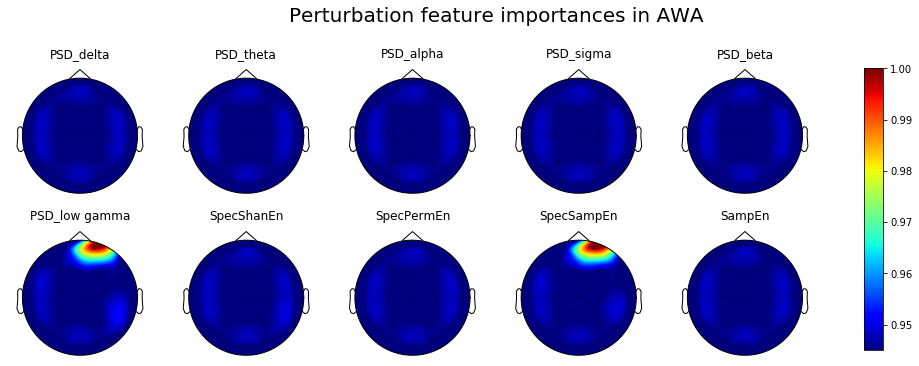

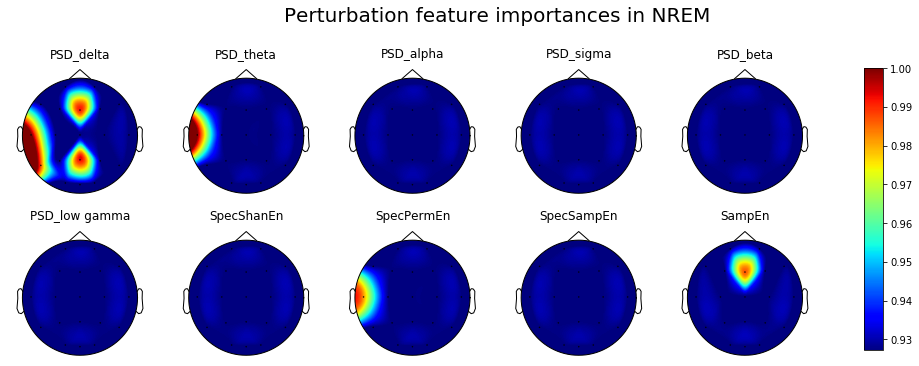

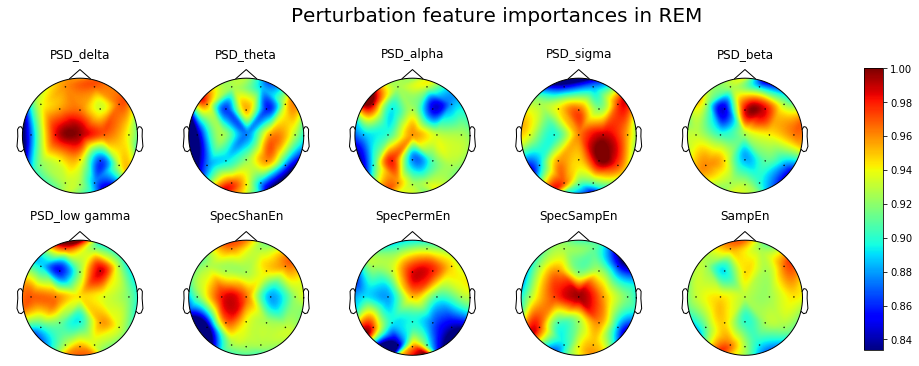

In [13]:
colormap = 'jet'

for stage in STAGES:
    axes = []
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Perturbation feature importances in {stage}', fontsize=20, y=1.1)
    
    curr_importances = scores[stage].reshape((20, -1))
    curr_importances = 1 - curr_importances
    curr_importances = curr_importances / curr_importances.max()
    vmin = np.min(curr_importances)
    vmax = np.max(curr_importances)
    
    for i in range(curr_importances.shape[1]):
        axes.append(plt.subplot(2, 5, i + 1))
        plt.title(feature_names[i])
        curr = curr_importances[:,i]
        viz.plot_topomap(curr, sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.show()